In [1]:
import torch
from PIL import Image
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision.transforms import functional as F_t
import torchvision.ops as ops
from torchvision.transforms.functional import to_tensor
from torchvision.transforms.functional import to_pil_image

from util.box_ops import box_xyxy_to_cxcywh, box_cxcywh_to_xyxy

from scipy.spatial.distance import mahalanobis

from models import build_model
from models.matcher import build_matcher

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import seaborn as sns

from collections import Counter

import util.misc as utils

from util import box_ops
from util.misc import NestedTensor
from torch.utils.data import DataLoader

from datasets.torchvision_datasets.open_world import OWDetection
from datasets.coco import make_coco_transforms

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import umap.umap_ as umap

from tqdm import tqdm
import json
import os

from args import Args

{'OWDETR': ('aeroplane', 'bicycle', 'bird', 'boat', 'bus', 'car', 'cat', 'cow', 'dog', 'horse', 'motorbike', 'sheep', 'train', 'elephant', 'bear', 'zebra', 'giraffe', 'truck', 'person', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'chair', 'diningtable', 'pottedplant', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'bed', 'toilet', 'sofa', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'tvmonitor', 'bottle', 'unknown'), 'TOWOD': ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = Args()

# 모델과 postprocessor 준비
model, _, postprocessors, exemplar_selection, contextual_labeling = build_model(args, mode=args.model_type)
model.to(device)

# 체크포인트 로드 (옵션) / Load checkpoint (optional)
checkpoint = torch.load("./test_model/pretrain/t1.pth", map_location=device)
model.load_state_dict(checkpoint['model'], strict=False)
model.eval()

Invalid class range: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
DINO resnet50


/home/yongho/miniconda3/envs/openmmlab/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/yongho/miniconda3/envs/openmmlab/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


running with exemplar_replay_selection
Initialized Contextual Labeling Module


DeformableDETR(
  (transformer): DeformableTransformer(
    (encoder): DeformableTransformerEncoder(
      (layers): ModuleList(
        (0): DeformableTransformerEncoderLayer(
          (self_attn): MSDeformAttn(
            (sampling_offsets): Linear(in_features=256, out_features=256, bias=True)
            (attention_weights): Linear(in_features=256, out_features=128, bias=True)
            (value_proj): Linear(in_features=256, out_features=256, bias=True)
            (output_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (dropout1): Dropout(p=0.1, inplace=False)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout2): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (dropout3): Dropout(p=0.1, inplace=False)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affin

In [4]:
def get_datasets(args):
    print(args.dataset)

    train_set = args.train_set
    test_set = args.test_set
    dataset_train = OWDetection(args, args.data_root, image_set=args.train_set, transforms=make_coco_transforms(args.train_set), dataset = args.dataset)
    dataset_val = OWDetection(args, args.data_root, image_set=args.test_set, dataset = args.dataset, transforms=make_coco_transforms(args.test_set))

    print(args.train_set)
    print(args.test_set)
    print(dataset_train)
    print(dataset_val)

    return dataset_train, dataset_val

def preprocess_image(image_path, device):
    """
    쿼리 이미지 전처리 함수: 모델이 요구하는 입력 형식으로 변환
    """
    image = Image.open(image_path).convert('RGB')
    w, h = image.size

    transform = T.Compose([
        T.Resize(800),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    img_tensor = transform(image).unsqueeze(0).to(device)  # (1, C, H, W)
    return NestedTensor(img_tensor, torch.zeros_like(img_tensor[:, 0]))  # NestedTensor 변환

def apply_nms(boxes, scores, labels, iou_threshold=0.5):
    """
    NMS 적용 함수
    
    Args:
        boxes: 바운딩 박스 좌표 [N, 4]
        scores: 각 박스의 confidence score [N]
        labels: 각 박스의 클래스 레이블 [N]
        iou_threshold: NMS에서 사용할 IoU threshold
    """
    # 클래스별로 NMS 적용
    unique_labels = torch.unique(labels)
    keep_boxes = []
    keep_scores = []
    keep_labels = []
    
    for label in unique_labels:
        # 현재 클래스의 박스들만 선택
        class_mask = labels == label
        class_boxes = boxes[class_mask]
        class_scores = scores[class_mask]
        
        # NMS 적용
        keep_idx = ops.nms(class_boxes, class_scores, iou_threshold)
        
        # 결과 저장
        keep_boxes.append(boxes[class_mask][keep_idx])
        keep_scores.append(scores[class_mask][keep_idx])
        keep_labels.append(labels[class_mask][keep_idx])
    
    # 모든 클래스의 결과 합치기
    if keep_boxes:
        keep_boxes = torch.cat(keep_boxes)
        keep_scores = torch.cat(keep_scores)
        keep_labels = torch.cat(keep_labels)
        return keep_boxes, keep_scores, keep_labels
    else:
        return boxes, scores, labels

def visualize_detection(image, outputs, class_names, known_score_threshold=0.3, unknown_score_threshold=0.6, unknown_label_id=80, iou_threshold=0.5):
    """
    Detection 결과 시각화 함수 (NMS 포함)
    """
    plt.figure(figsize=(12, 12))
    ax = plt.gca()
    
    # 이미지 표시
    ax.imshow(image)
    
    # 색상 맵 설정
    colors = plt.cm.rainbow(np.linspace(0, 1, unknown_label_id))
    
    # 첫 번째 이미지의 결과 가져오기
    result = outputs[0]
    
    # 각 detection에 대해
    scores = result['scores'].cpu()
    labels = result['labels'].cpu()
    boxes = result['boxes'].cpu()
    
    # score threshold 적용
    known_keep = (labels < unknown_label_id) & (scores > known_score_threshold)
    unknown_keep = (labels == unknown_label_id) & (scores > unknown_score_threshold)
    keep = known_keep | unknown_keep
    scores = scores[keep]
    labels = labels[keep]
    boxes = boxes[keep]
    
    # NMS 적용
    boxes, scores, labels = apply_nms(boxes, scores, labels, iou_threshold)
    
    for score, label, box in zip(scores, labels, boxes):
        cls_id = label.item()
        
        # 박스 좌표
        xmin = float(box[0])
        ymin = float(box[1])
        xmax = float(box[2])
        ymax = float(box[3])
        
        # 박스 그리기
        rect = patches.Rectangle(
            (xmin, ymin), 
            xmax - xmin, 
            ymax - ymin, 
            linewidth=2, 
            edgecolor=colors[cls_id] if cls_id < unknown_label_id else 'red',
            facecolor='none'
        )
        ax.add_patch(rect)
        
        # 클래스 레이블과 confidence score 표시
        class_name = class_names[cls_id]
        ax.text(
            xmin, ymin - 5,
            f'{class_name} {score:.2f}',
            color=colors[cls_id] if cls_id < unknown_label_id else 'red',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'),
            fontsize=8
        )
    
    plt.axis('off')
    plt.show()


def run_inference(model, postprocessors, image_path, device='cuda'):
    """
    이미지에 대한 전체 추론 과정을 수행
    """
    # 이미지 로드
    image = Image.open(image_path).convert('RGB')
    w, h = image.size
    
    # 이미지 전처리
    transform = T.Compose([
        T.Resize([800]),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img_tensor = transform(image).unsqueeze(0).to(device)
    print(f"Image shape: {img_tensor.shape}")

    # 원본 이미지 크기
    target_sizes = torch.tensor([[h, w]], device=device)
    
    # 모델 추론
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        results = postprocessors['bbox'](outputs, target_sizes)
    
    return image, results

In [5]:
class_names = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor', 'truck', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'bed', 'toilet', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'unknown']

In [6]:
dataset_train, dataset_val = get_datasets(args)

sampler_train = torch.utils.data.RandomSampler(dataset_train)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

batch_sampler_train = torch.utils.data.BatchSampler(sampler_train, args.batch_size, drop_last=True)
data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                                collate_fn=utils.collate_fn, num_workers=args.num_workers,
                                pin_memory=True)
data_loader_val = DataLoader(dataset_val, args.batch_size, sampler=sampler_val,
                                drop_last=False, collate_fn=utils.collate_fn, num_workers=args.num_workers,
                                pin_memory=True)

TOWOD
owod_t1_train
owod_all_task_test
Dataset OWDetection
    Number of datapoints: 16551
    Root location: ./data/OWOD
    [['train'], Compose(
    Compose(
)
)]
Dataset OWDetection
    Number of datapoints: 10246
    Root location: ./data/OWOD
    [['test'], Compose(
    Compose(
)
)]


In [7]:
def extract_matched_embeddings(model, matcher, data_loader, device, save_path="matched_embeddings.npz"):
    """
    모든 테스트 이미지에서 GT에 매칭된 query embedding, label, box, score를 추출하고 저장하는 함수
    """
    if os.path.exists(save_path):
        print(f"✅ 이미 존재하는 matched embeddings 파일: {save_path}")
        return

    model.eval()
    all_embeddings = []
    all_labels = []
    all_boxes = [] # cx, cy, w, h
    all_logits = []
    all_obj = []
    all_scores = []

    with torch.no_grad():
        for samples, targets in tqdm(data_loader, desc="Extracting matched queries"):
            samples = samples.to(device)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(samples)
            embeddings = outputs["query_embeddings"]  # [B, Q, D]
            pred_boxes = outputs["pred_boxes"]
            pred_logits = outputs["pred_logits"]
            pred_obj = outputs["pred_obj"]  # objectness

            matched_indices = matcher(outputs, targets)

            for b_idx, (src_idx, tgt_idx) in enumerate(matched_indices):
                if len(src_idx) == 0:
                    continue

                # embedding, box, logit 저장
                matched_q = embeddings[b_idx][src_idx]
                matched_boxes = pred_boxes[b_idx][src_idx]
                matched_logits = pred_logits[b_idx][src_idx]
                matched_obj = pred_obj[b_idx][src_idx]

                all_embeddings.append(matched_q.cpu())
                all_boxes.append(matched_boxes.cpu())
                all_logits.append(matched_logits.cpu())
                all_obj.append(matched_obj.cpu())

                obj_prob = torch.exp(-(args.obj_temp/args.hidden_dim) * matched_obj).unsqueeze(-1)  # [M]
                final_score = (obj_prob * matched_logits.sigmoid()).cpu()  # [M]
                all_scores.append(final_score)

                labels_this_batch = targets[b_idx]["labels"][tgt_idx].cpu().tolist()
                all_labels.extend(labels_this_batch)

    # numpy로 변환 및 저장
    all_embeddings = torch.cat(all_embeddings, dim=0).numpy()
    all_labels = np.array(all_labels)
    all_boxes = torch.cat(all_boxes, dim=0).numpy()
    all_logits = torch.cat(all_logits, dim=0).numpy()
    all_scores = torch.cat(all_scores, dim=0).numpy()
    all_obj = torch.cat(all_obj, dim=0).numpy()

    np.savez(save_path, embeddings=all_embeddings, labels=all_labels,
             boxes=all_boxes, logits=all_logits, scores=all_scores, obj=all_obj)
    print(f"✅ Matched embeddings 저장 완료: {save_path} | 개수: {len(all_embeddings)}")

    return all_embeddings, all_labels, all_boxes, all_scores, all_obj

def extract_unmatched_embeddings_from_image(model, matcher, image_tensor, target, device, save_path="unmatched_embedding.npz", top_k=10, largest=True, criterion="obj"):
    model.eval()
    
    image_tensor = image_tensor.to(device)
    target = [{k: v.to(device) for k, v in target.items()}]

    with torch.no_grad():
        outputs = model(image_tensor)
        query_embeddings = outputs["query_embeddings"][0]  # [Q, D]
        pred_boxes = outputs["pred_boxes"][0]              # [Q, 4]
        pred_logits = outputs["pred_logits"][0]            # [Q, C+1]
        pred_obj = outputs["pred_obj"][0]                  # [Q]

        obj_prob = torch.exp(-(args.obj_temp/args.hidden_dim) * pred_obj).unsqueeze(-1)
        prob = obj_prob * pred_logits.sigmoid()

        # 1. matcher로 matched query index 확인
        matched_indices = matcher(outputs, target)[0]
        matched_query_indices = matched_indices[0].cpu().tolist()

        # 2. unmatched 인덱스 추출
        all_indices = set(range(pred_logits.shape[0]))
        unmatched_indices = list(all_indices - set(matched_query_indices))

        if len(unmatched_indices) == 0:
            print("⚠️ unmatched 쿼리가 없습니다.")
            return None, None, None

        topk = min(top_k, len(unmatched_indices))
        topk_indices = None
        if criterion == "obj":
            unmatched_scores = pred_obj[unmatched_indices]  # objectness scores
            topk_indices = torch.topk(unmatched_scores, k=topk, largest=largest).indices
        else:
            unmatched_scores = prob[unmatched_indices] # prob scores
            topk_indices = torch.topk(unmatched_scores, k=topk, largest=largest).indices
            
        selected_indices = [unmatched_indices[i] for i in topk_indices.cpu().tolist()]

        # 3. 상위 objectness 기반 선택
        unmatched_embeddings = query_embeddings[selected_indices].cpu().numpy()
        unmatched_boxes = pred_boxes[selected_indices].cpu().numpy()
        unmatched_scores = unmatched_scores[selected_indices].cpu().numpy()
        unmathced_logits = pred_logits[selected_indices].softmax(-1).max(-1).values.cpu().numpy()

        # 4. 저장
        np.savez(save_path,
                 embeddings=unmatched_embeddings,
                 boxes=unmatched_boxes,
                 logits=unmathced_logits,
                 scores=unmatched_scores)
        print(f"✅ Unmatched query (Top-{topk}) 저장 완료: {save_path}")

        return unmatched_embeddings, unmatched_boxes, unmatched_scores

def visualize_matched_vs_unmatched(matched_path, unmatched_path, method="PCA"):
    matched = np.load(matched_path)
    unmatched = np.load(unmatched_path)

    matched_embeddings = matched["embeddings"]
    matched_labels = matched["labels"]
    unmatched_embeddings = unmatched["embeddings"]

    all_embeddings = np.concatenate([matched_embeddings, unmatched_embeddings], axis=0)
    matched_len = len(matched_embeddings)

    # 차원 축소
    if method == "PCA":
        reducer = PCA(n_components=2)
    elif method == "T-SNE":
        reducer = TSNE(n_components=2, perplexity=30, random_state=42, n_jobs=-1)
    elif method == "UMAP":
        reducer = umap.UMAP(n_components=2, random_state=42)
    else:
        raise ValueError("method must be 'PCA', 'T-SNE', or 'UMAP'")

    reduced = reducer.fit_transform(all_embeddings)

    # 시각화
    plt.figure(figsize=(10, 7))
    unique_labels = np.unique(matched_labels)
    cmap = plt.get_cmap("tab20", lut=len(unique_labels))
    label_to_color = {label: cmap(i) for i, label in enumerate(unique_labels)}

    # ✅ matched part만 slicing해서 마스크 적용
    reduced_matched = reduced[:matched_len]

    for i, label in enumerate(unique_labels):
        mask = (matched_labels == label)
        plt.scatter(reduced_matched[mask, 0], reduced_matched[mask, 1],
                    s=10, alpha=0.6,
                    label=f"{str(label)} {class_names[label]}", color=label_to_color[label])

    # ✅ unmatched part 시각화
    reduced_unmatched = reduced[matched_len:]
    plt.scatter(reduced_unmatched[:, 0], reduced_unmatched[:, 1],
                s=80, c='red', marker='X', label='unmatched')

    plt.title(f"{method} visualization: matched vs unmatched")
    plt.xlabel(f"{method}-1")
    plt.ylabel(f"{method}-2")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def get_sample_from_dataloader(data_loader, index):
    """
    DataLoader 내부의 Dataset에서 특정 인덱스의 데이터를 가져오는 함수

    Args:
        data_loader: PyTorch DataLoader 객체
        index (int): 추출할 데이터 인덱스

    Returns:
        image_tensor: shape (1, 3, H, W)
        target: dict
    """
    dataset = data_loader.dataset
    image, target = dataset[index]

    if isinstance(image, np.ndarray):
        image = to_tensor(image)

    if image.ndim == 3:
        image = image.unsqueeze(0)  # [3, H, W] → [1, 3, H, W]

    return image, target

In [8]:
matcher = build_matcher(args)

In [9]:
save_path="matched_embeddings.npz"

if os.path.exists(save_path):
    print(f"✅ 이미 존재하는 matched embeddings 파일: {save_path}")
    data = np.load(save_path)
else:
    all_embeddings, all_labels, all_boxes, all_scores, all_obj = extract_matched_embeddings(model, matcher, data_loader_val, device, save_path="matched_embeddings.npz")

✅ 이미 존재하는 matched embeddings 파일: matched_embeddings.npz


In [12]:
def topk_similarity(matched_embeddings, matched_labels, unmatched_embeddings, top_k=5):
    results = []
    sim_matrix = cosine_similarity(unmatched_embeddings, matched_embeddings)  # [U, M]

    for i, sims in enumerate(sim_matrix):
        topk_idx = sims.argsort()[-top_k:][::-1]
        topk_labels = matched_labels[topk_idx]
        label_counts = Counter(topk_labels)
        top1 = topk_labels[0]
        results.append({
            "unmatched_index": i,
            "top1": int(top1),
            "topk": topk_labels.tolist(),
            "topk_dist": dict(label_counts)
        })

    return results

def visualize_top1_distribution(results, class_names, save_path):
    top1_labels = [r['top1'] for r in results]
    counts = Counter(top1_labels)
    labels = [class_names[i] for i in counts.keys()]
    values = list(counts.values())

    plt.figure(figsize=(12, 6))
    sns.barplot(x=labels, y=values, palette="tab20")
    plt.title("Top-1 Predicted Class Distribution (Unmatched Queries)")
    plt.xticks(rotation=45)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

def run_similarity_analysis(matched_path, unmatched_path, class_names, top_k=5, save_dir="./similarity_results"):
    os.makedirs(save_dir, exist_ok=True)

    matched = np.load(matched_path)
    unmatched = np.load(unmatched_path)

    matched_embeddings = matched["embeddings"]
    matched_labels = matched["labels"]
    unmatched_embeddings = unmatched["embeddings"]

    results = topk_similarity(matched_embeddings, matched_labels, unmatched_embeddings, top_k)

    json_path = os.path.join(save_dir, "unmatched_topk_similarity.json")
    with open(json_path, "w") as f:
        json.dump(results, f, indent=2)
    print(f"✅ JSON 저장 완료: {json_path}")

    plot_path = os.path.join(save_dir, "top1_distribution.png")
    visualize_top1_distribution(results, class_names, plot_path)
    print(f"📊 시각화 저장 완료: {plot_path}")

    return results


def experiment_1_combined_visualization(image_tensor, target, matched_path, unmatched_path, method="PCA", class_names=class_names):
    # --- 1. 임베딩 로드 ---
    matched = np.load(matched_path)
    unmatched = np.load(unmatched_path)

    inv_normalize = T.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )

    matched_embeddings = matched["embeddings"]
    matched_labels = matched["labels"]
    unmatched_embeddings = unmatched["embeddings"]
    unmatched_boxes = unmatched["boxes"]
    unmatched_labels = np.array(["unknown"] * len(unmatched_embeddings))

    # --- 2. 차원 축소 ---
    all_embeddings = np.concatenate([matched_embeddings, unmatched_embeddings], axis=0)
    all_labels = np.concatenate([matched_labels, unmatched_labels], axis=0)
    matched_len = len(matched_embeddings)

    if method == "PCA":
        reducer = PCA(n_components=2)
    elif method == "T-SNE":
        reducer = TSNE(n_components=2, perplexity=30, random_state=42)
    elif method == "UMAP":
        reducer = umap.UMAP(n_components=2, random_state=42)
    else:
        raise ValueError("지원하지 않는 차원 축소 방식입니다.")

    reduced = reducer.fit_transform(all_embeddings)

    # --- 3. 시각화 준비 ---
    image = inv_normalize(image_tensor.squeeze(0).cpu())
    image = to_pil_image(image)
    img_w, img_h = image.size

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    # --- 📊 좌측: 임베딩 PCA 시각화 ---
    unique_labels = np.unique(matched_labels)
    cmap = plt.get_cmap("tab20", len(unique_labels))
    label_to_color = {label: cmap(i) for i, label in enumerate(unique_labels)}

    reduced_matched = reduced[:matched_len]
    for i, label in enumerate(unique_labels):
        mask = (matched_labels == label)
        label_name = class_names[label] if class_names else str(label)
        ax1.scatter(reduced_matched[mask, 0], reduced_matched[mask, 1],
                    s=10, alpha=0.5, color=label_to_color[label],
                    label=f"[{i}] {class_names[i]}")

    reduced_unmatched = reduced[matched_len:]
    ax1.scatter(reduced_unmatched[:, 0], reduced_unmatched[:, 1],
                s=80, c='red', marker='X', label='unmatched')

    for i, (x, y) in enumerate(reduced_unmatched):
        ax1.text(x + 0.2, y + 0.2, f"Q{i}", fontsize=10, color='black',
                 bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.2'))

    ax1.set_title("PCA | Matched vs. Unmatched Queries")
    ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9)
    ax1.grid(True)

    # --- 🖼️ 우측: 이미지 + GT + Unmatched 박스 ---
    ax2.imshow(image)

    # GT box
    gt_boxes = target["boxes"].cpu().numpy()
    gt_labels = target["labels"].cpu().numpy()

    for box, label in zip(gt_boxes, gt_labels):
        x_c, y_c, w, h = box
        x1 = (x_c - w / 2) * img_w
        y1 = (y_c - h / 2) * img_h
        w *= img_w
        h *= img_h
        label_name = class_names[label] if class_names else str(label)
        ax2.add_patch(Rectangle((x1, y1), w, h, edgecolor='lime', facecolor='none', linewidth=2))
        ax2.text(x1, y1 - 5, label_name, color='black', fontsize=11,
                 bbox=dict(facecolor='lime', edgecolor='none', alpha=0.6, pad=0.2))

    for i, box in enumerate(unmatched_boxes):
        cx, cy, bw, bh = box

        x1 = max(0, (cx - bw / 2) * img_w)
        y1 = max(0, (cy - bh / 2) * img_h)
        x2 = min(img_w, (cx + bw / 2) * img_w)
        y2 = min(img_h, (cy + bh / 2) * img_h)

        bw = x2 - x1
        bh = y2 - y1

        ax2.add_patch(Rectangle((x1, y1), bw, bh,
                                edgecolor='red', facecolor='none', linewidth=2))
        ax2.text(x1, y1 - 5, f"Q{i}", color='black', fontsize=11,
                 bbox=dict(facecolor='white', edgecolor='red', pad=0.2))

    ax2.set_title("GT Boxes (Green) + Unmatched (Red, Indexed)")
    ax2.axis('off')

    plt.tight_layout()
    plt.show()


def compute_unmatched_to_matched_similarity(unmatched_path, matched_path, topk=1, save_path="unmatched_topk_similarity.json"):
    """
    Unmatched 쿼리와 전체 matched 쿼리 간의 Cosine 유사도 기반 top-k 결과를 저장

    Args:
        unmatched_path (str): "unmatched_embedding.npz" 경로
        matched_path (str): "matched_embeddings.npz" 경로
        topk (int): top-k 유사한 matched 쿼리 추출
        save_path (str): 저장할 JSON 경로

    저장 형식:
    {
        "Q0": [{"matched_idx": 123, "similarity": 0.92}, ...],
        "Q1": [{"matched_idx": 45, "similarity": 0.88}, ...],
        ...
    }
    """
    # ① 로드
    unmatched = np.load(unmatched_path)
    matched = np.load(matched_path)

    unmatched_embeddings = torch.tensor(unmatched["embeddings"])  # [U, D]
    matched_embeddings = torch.tensor(matched["embeddings"])      # [M, D]

    # ② Normalize (cosine similarity 위해)
    unmatched_norm = F.normalize(unmatched_embeddings, dim=1)  # [U, D]
    matched_norm = F.normalize(matched_embeddings, dim=1)      # [M, D]

    # ③ Cosine 유사도 계산
    similarity_matrix = torch.matmul(unmatched_norm, matched_norm.T)  # [U, M]

    # ④ Top-K 추출
    topk_scores, topk_indices = torch.topk(similarity_matrix, k=topk, dim=1)  # [U, K]

    result = {}
    for i in range(len(unmatched_embeddings)):
        result[f"Q{i}"] = []
        for j in range(topk):
            idx = topk_indices[i][j].item()
            score = topk_scores[i][j].item()
            result[f"Q{i}"].append({"matched_idx": idx, "similarity": round(score, 4)})

    # ⑤ 저장
    with open(save_path, 'w') as f:
        json.dump(result, f, indent=2)
    
    print(f"✅ 유사도 계산 완료: Top-{topk} matched 쿼리 저장 → {save_path}")
    return result

def visualize_top1_matched_boxes(
    unmatched_idx, 
    unmatched_path, 
    matched_path, 
    similarity_json, 
    matched_image_indices, 
    matched_boxes_all, 
    data_loader, 
    class_names
):
    """
    Top-1 matched 쿼리의 바운딩 박스를 시각화하여 unmatched 쿼리와 비교

    Args:
        unmatched_idx (int): 비교할 unmatched 쿼리 인덱스 (예: 0)
        unmatched_path (str): unmatched_embedding.npz 경로
        matched_path (str): matched_embeddings.npz 경로
        similarity_json (str): top-1 결과 JSON 경로
        matched_image_indices (list[int]): matched 임베딩의 원 이미지 인덱스 리스트
        matched_boxes_all (np.ndarray): matched_embedding.npz에서 로드한 모든 박스
        data_loader (DataLoader): 이미지와 GT를 불러올 수 있는 DataLoader
        class_names (list[str]): 클래스 이름 리스트
    """
    # --- ① 유사도 결과 불러오기 ---
    with open(similarity_json, 'r') as f:
        sim_result = json.load(f)

    top1 = sim_result[f"Q{unmatched_idx}"][0]
    matched_idx = top1["matched_idx"]
    similarity = top1["similarity"]
    matched_image_idx = matched_image_indices[matched_idx]
    matched_box = matched_boxes_all[matched_idx]

    # --- ② 이미지 가져오기 ---
    unmatched_img_tensor, unmatched_target = get_sample_from_dataloader(data_loader, index=unmatched_target_idx)
    matched_img_tensor, matched_target = get_sample_from_dataloader(data_loader, index=matched_image_idx)

    unmatched_img = to_pil_image(unmatched_img_tensor.squeeze(0).cpu())
    matched_img = to_pil_image(matched_img_tensor.squeeze(0).cpu())

    unmatched_box = np.load(unmatched_path)["boxes"][unmatched_idx]

    # --- ③ 시각화 ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # ⬅️ Unmatched 이미지
    ax1.imshow(unmatched_img)
    h1, w1 = unmatched_img.height, unmatched_img.width
    box = box_cxcywh_to_xyxy(torch.tensor(unmatched_box)).numpy()
    box *= np.array([w1, h1, w1, h1])
    x1, y1, x2, y2 = box.astype(int)
    ax1.add_patch(Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='red', linewidth=2, facecolor='none'))
    ax1.text(x1, y1 - 5, f"Unmatched Q{unmatched_idx}", color='red', fontsize=12)
    ax1.set_title("Unmatched Query Box")

    # ➡️ Top-1 Matched 이미지
    ax2.imshow(matched_img)
    h2, w2 = matched_img.height, matched_img.width
    box2 = box_cxcywh_to_xyxy(torch.tensor(matched_box)).numpy()
    box2 *= np.array([w2, h2, w2, h2])
    x1_m, y1_m, x2_m, y2_m = box2.astype(int)
    ax2.add_patch(Rectangle((x1_m, y1_m), x2_m-x1_m, y2_m-y1_m, edgecolor='blue', linewidth=2, facecolor='none'))
    ax2.text(x1_m, y1_m - 5, f"Top-1 Match\n(sim={similarity:.2f})", color='blue', fontsize=12)
    ax2.set_title(f"Matched Query Box\n[Image #{matched_image_idx}]")

    plt.tight_layout()
    plt.show()

def run_full_experiment_1_pipeline(model, matcher, data_loader_val, device,
                                   matched_embeddings_path="matched_embeddings.npz",
                                   save_dir="results", test_index=0, topk=1, method="PCA", criterion="obj"):
    """
    실험 1 전체 자동화 파이프라인: 차원 축소, 시각화, topk 유사도 바운딩 박스 비교

    Args:
        model: 학습된 OWOD 모델
        matcher: HungarianMatcher 객체
        data_loader_val: 테스트용 DataLoader
        device: torch.device
        matched_embeddings_path: 전체 matched 저장 경로
        save_dir: 결과 저장 디렉토리
        test_index: 시각화 대상 이미지 인덱스
        topk: 가장 유사한 top-k matched 쿼리 시각화
        method: 차원 축소 방법 ("PCA", "T-SNE", "UMAP")
    """
    os.makedirs(save_dir, exist_ok=True)

    # ① 테스트 이미지 한 장 가져오기
    image_tensor, target = get_sample_from_dataloader(data_loader_val, test_index)

    # ② unmatched query 추출
    extract_unmatched_embeddings_from_image(
        model, matcher, image_tensor, target, device, save_path=f"{save_dir}/unmatched_embedding.npz", criterion=criterion
    )

    # ③ 차원 축소 + 시각화 + GT + Unmatched 박스 표시
    experiment_1_combined_visualization(
        image_tensor=image_tensor,
        target=target,
        matched_path=matched_embeddings_path,
        unmatched_path=f"{save_dir}/unmatched_embedding.npz",
        method=method
    )

    # ④ unmatched → matched 쿼리 유사도 계산
    compute_unmatched_to_matched_similarity(
        unmatched_path=f"{save_dir}/unmatched_embedding.npz",
        matched_path=matched_embeddings_path,
        topk=topk,
        save_path=f"{save_dir}/unmatched_topk_similarity.json"
    )

    # # ⑤ 유사도 결과 기반 바운딩 박스 비교 시각화
    # visualize_top1_matched_boxes(
    #     unmatched_path=f"{save_dir}/unmatched_embedding.npz",
    #     matched_path=matched_embeddings_path,
    #     original_image_tensor=image_tensor,
    #     original_target=target,
    #     class_names=class_names,
    #     similarity_json_path=f"{save_dir}/unmatched_topk_similarity.json",
    #     topk=topk,
    #     save_dir=save_dir
    # )

    print(f"🎉 실험 1 전체 파이프라인 완료! 결과 저장 위치: {save_dir}")

In [14]:
run_full_experiment_1_pipeline(
    model=model,
    matcher=matcher,
    data_loader_val=data_loader_val,
    device=device,
    test_index=2301,  # 임의의 테스트 이미지
    method="UMAP",
    topk=10,
    save_dir="results/exp1",
    criterion="prob"
)

TypeError: list indices must be integers or slices, not list

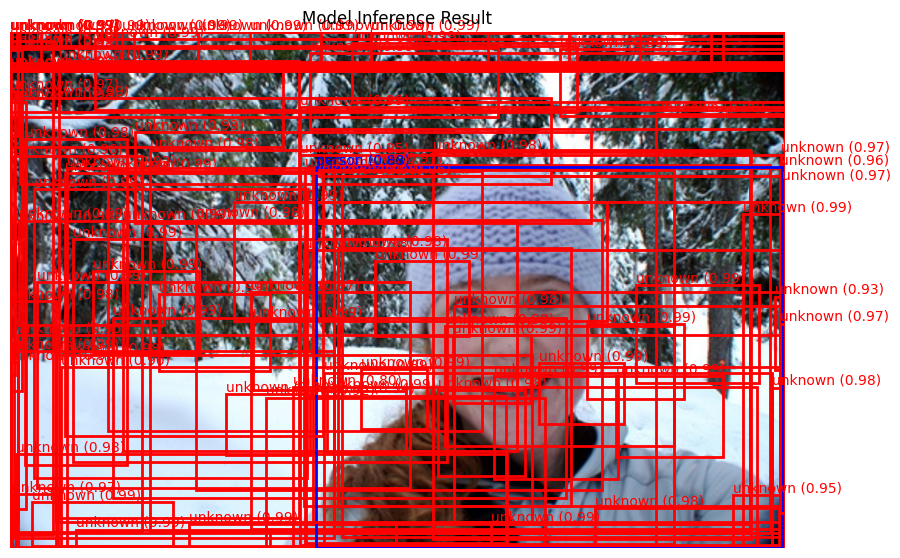

In [11]:
# --- 1. 이미지 불러오기 ---
image_tensor, target = get_sample_from_dataloader(data_loader_val, 2301)
inv_normalize = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
# --- 2. 모델 추론 ---
model.eval()
with torch.no_grad():
    outputs = model(image_tensor.to(device))

# --- 3. 출력 값 확인 ---
pred_logits = outputs["pred_logits"][0]     # [Q, C+1]
pred_boxes = outputs["pred_boxes"][0].cpu()       # [Q, 4]
pred_scores, pred_classes = pred_logits.softmax(-1).max(-1)

# --- 4. 시각화 ---
plt.figure(figsize=(10, 7))
image = inv_normalize(image_tensor.squeeze(0).cpu())
plt.imshow(image.permute(1, 2, 0).numpy())
img_h, img_w = image.shape[1:]

# 시각화 설정
threshold = 0.7
for i in range(pred_boxes.shape[0]):
    score = pred_scores[i].item()
    cls = pred_classes[i].item()
    if score < threshold:
        continue
    
    # box: cxcywh → xywh
    box = pred_boxes[i]
    cx, cy, bw, bh = box
    x1 = max(0, (cx - bw / 2) * img_w)
    y1 = max(0, (cy - bh / 2) * img_h)
    x2 = min(img_w, (cx + bw / 2) * img_w)
    y2 = min(img_h, (cy + bh / 2) * img_h)

    bw = x2 - x1
    bh = y2 - y1

    # 색상 및 텍스트
    color = "red" if cls == pred_logits.shape[1] - 1 else "blue"  # 마지막 클래스는 "unknown"
    label_text = "unknown" if cls == pred_logits.shape[1] - 1 else f"{class_names[cls]}"
    plt.gca().add_patch(Rectangle((x1, y1), bw, bh, edgecolor=color, facecolor='none', linewidth=2))
    plt.text(x1, y1 - 5, f"{label_text} ({score:.2f})", color=color, fontsize=10)

plt.axis("off")
plt.title("Model Inference Result")
plt.show()

In [120]:
# ① 테스트 이미지 한 장 가져오기
image_tensor, target = get_sample_from_dataloader(data_loader_val, 3000)

# ② unmatched query 추출
extract_unmatched_embeddings_from_image(
    model, matcher, image_tensor, target, device, save_path=f"results/unmatched_embedding2.npz", largest=False
)

✅ Unmatched query (Top-10) 저장 완료: results/unmatched_embedding2.npz


(array([[ 0.08324713, -0.30046833,  0.3091254 , ..., -0.0808865 ,
         -0.1971289 , -0.5171622 ],
        [ 0.09104126, -0.31570593,  0.308364  , ..., -0.02533788,
         -0.5326694 , -0.41679454],
        [ 0.21010461, -0.30162504,  0.703982  , ...,  0.04728319,
         -0.7733317 , -0.26764262],
        ...,
        [ 0.08063232, -0.5541202 ,  0.41820893, ...,  0.00931244,
         -0.34292904, -0.52456504],
        [ 0.03353389, -0.51318645,  0.22433284, ..., -0.40402666,
         -0.49546686, -0.7148632 ],
        [ 0.14028792, -0.39394757,  0.06187126, ...,  0.11779209,
         -0.26466426, -0.17741223]], dtype=float32),
 array([[0.7421745 , 0.8173658 , 0.07707881, 0.11925694],
        [0.8395542 , 0.73523045, 0.16506808, 0.23659809],
        [0.8692096 , 0.7793078 , 0.10341983, 0.16148844],
        [0.83612007, 0.7525175 , 0.15964542, 0.20493156],
        [0.10404778, 0.56036025, 0.18376683, 0.5526788 ],
        [0.8744114 , 0.79188275, 0.10064499, 0.14278436],
        [0

In [53]:
image, target = data_loader_val.dataset[10]

outputs=model([image.to(device)])
print(outputs)

{'pred_logits': tensor([[[-6.1214, -5.8972, -6.0757,  ..., -5.2657, -4.5605,  4.0885],
         [-5.1857, -5.0916, -4.9081,  ..., -4.3269, -5.7489,  2.6072],
         [-6.2278, -5.9105, -6.1259,  ..., -4.9269, -4.7776,  4.5232],
         ...,
         [-6.5271, -5.4826, -6.4804,  ..., -4.8180, -4.1712,  3.9374],
         [-4.9055, -4.1408, -5.0743,  ..., -3.8013, -5.9034,  1.8395],
         [-4.3515, -3.4200, -4.2626,  ..., -4.1453, -5.6245,  1.9416]]],
       device='cuda:0', grad_fn=<SelectBackward0>), 'pred_boxes': tensor([[[0.2064, 0.6009, 0.3501, 0.3148],
         [0.9943, 0.4360, 0.0116, 0.5114],
         [0.0421, 0.1957, 0.1143, 0.1664],
         [0.7841, 0.5618, 0.3705, 0.1987],
         [0.6906, 0.2698, 0.6044, 0.1805],
         [0.9955, 0.5699, 0.0088, 0.4646],
         [0.7322, 0.5457, 0.2070, 0.1480],
         [0.5136, 0.9877, 0.5159, 0.0332],
         [0.9918, 0.8271, 0.0323, 0.3186],
         [0.4467, 0.6443, 0.5589, 0.5456],
         [0.4319, 0.5936, 0.5242, 0.4965],
   

In [58]:
result = postprocessors['bbox'](outputs, target['orig_size'].unsqueeze(0).to(device))

/home/dan/Desktop/Contextual_Labeling/models/prob_deformable_detr.py:539: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  topk_boxes = topk_indexes // out_logits.shape[2] # 각 인덱스가 속한 바운딩 박스 인덱스


In [67]:
un1 = np.load("results/unmatched_embedding1.npz")
un1_embeddings = un1["embeddings"]
un1_boxes = un1["boxes"]
un1_scores = un1["scores"]
un1_logits = un1["logits"]

un1_2 = np.load("results/unmatched_embedding1_2.npz")
un1_2_embeddings = un1_2["embeddings"]
un1_2_boxes = un1_2["boxes"]
un1_2_scores = un1_2["scores"]

un2 = np.load("results/unmatched_embedding2.npz")
un2_embeddings = un2["embeddings"]
un2_boxes = un2["boxes"]
un2_scores = un2["scores"]

un2_2 = np.load("results/unmatched_embedding2_2.npz")
un2_2_embeddings = un2_2["embeddings"]
un2_2_boxes = un2_2["boxes"]
un2_2_scores = un2_2["scores"]

In [68]:
un1_boxes

array([[0.58774114, 0.4280352 , 0.09721904, 0.2602953 ],
       [0.5828488 , 0.4455936 , 0.08848691, 0.22927979],
       [0.58321816, 0.44747347, 0.0829633 , 0.22140133],
       [0.2793372 , 0.5066392 , 0.17951332, 0.20077378],
       [0.5875503 , 0.4443705 , 0.08050582, 0.21102351],
       [0.9629353 , 0.95275956, 0.06832392, 0.09222444],
       [0.9918367 , 0.55967444, 0.01593946, 0.30732217],
       [0.00651371, 0.4384459 , 0.0127425 , 0.25268775],
       [0.9945527 , 0.62472904, 0.01138256, 0.32389355],
       [0.9964977 , 0.33901107, 0.008192  , 0.34678   ]], dtype=float32)

In [69]:
un1_scores.shape

(10, 81)

In [70]:
un1_logits.shape

(10,)

In [71]:
topk_values, topk_indexes = torch.topk(torch.tensor(un1_scores).view(un1_logits.shape[0], -1), 10, dim=1)

In [ ]:
outputs['pred_logits'].shape

torch.Size([1, 100, 81])

In [77]:
outputs['pred_obj'].shape

torch.Size([1, 100])

In [ ]:
torch.exp(-(args.obj_temp/args.hidden_dim)*outputs['pred_obj']).unsqueeze(-1)

torch.Size([1, 100, 1])

In [83]:
outputs['pred_logits'].sigmoid().shape

torch.Size([1, 100, 81])

In [ ]:
result[0]['scores']

torch.Size([100])

In [73]:
un2_boxes

array([[0.96364534, 0.03067971, 0.9999163 , 0.06505932],
       [0.736795  , 0.03681353, 0.99997723, 0.06724789],
       [0.5403548 , 0.02564656, 0.99992454, 0.06780002],
       [0.3140706 , 0.0304261 , 0.99968886, 0.0698837 ],
       [0.63910544, 0.03458169, 0.9999465 , 0.06990928],
       [0.21887645, 0.02787162, 0.99947673, 0.06439851],
       [0.12608072, 0.03408796, 0.99958855, 0.06709254],
       [0.8992458 , 0.02409922, 0.9999703 , 0.0553339 ],
       [0.94493026, 0.04931689, 0.99949074, 0.07230631],
       [0.40529194, 0.03596122, 0.99997556, 0.07500044]], dtype=float32)

In [74]:
un2_scores

array([0.9894048 , 0.9912986 , 0.9920048 , 0.9922213 , 0.99132746,
       0.99204046, 0.992546  , 0.9890443 , 0.99169606, 0.99203837],
      dtype=float32)

In [75]:
un2_2_scores

array([0.70913035, 0.7946238 , 0.79672676, 0.83101636, 0.9464024 ,
       0.89993674, 0.91462237, 0.9587501 , 0.96473175, 0.9572345 ],
      dtype=float32)